#  EagleEye_v7 tutorial


We import necessary libraries and set up custom plot configurations for consistency.

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Directory setup for custom modules
import sys
module_path = '../../eagleeye'
sys.path.append(module_path)
import EagleEye_v7

# Custom plotting settings
sns.set(style="darkgrid")
plt.rcParams.update({
    'axes.titlesize': 21,
    'axes.labelsize': 17,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'grid.color': 'gray'
})


## 1. Generate the datasets 

In [4]:
from utils_37 import generate_uniform_with_Gaussian_ove_under

# Generate data with anomalies
num_points = 100000
anomaly_sizes_o = [50, 100, 200, 300, 500, 700, 900]
anomaly_sizes_u = [ 100, 300, 700, ]
n_dim = 3

reference_data, test_data = generate_uniform_with_Gaussian_ove_under(n_dim, num_points, anomaly_sizes_o, anomaly_sizes_u)


### 1.1 Visualize the generated datasets 

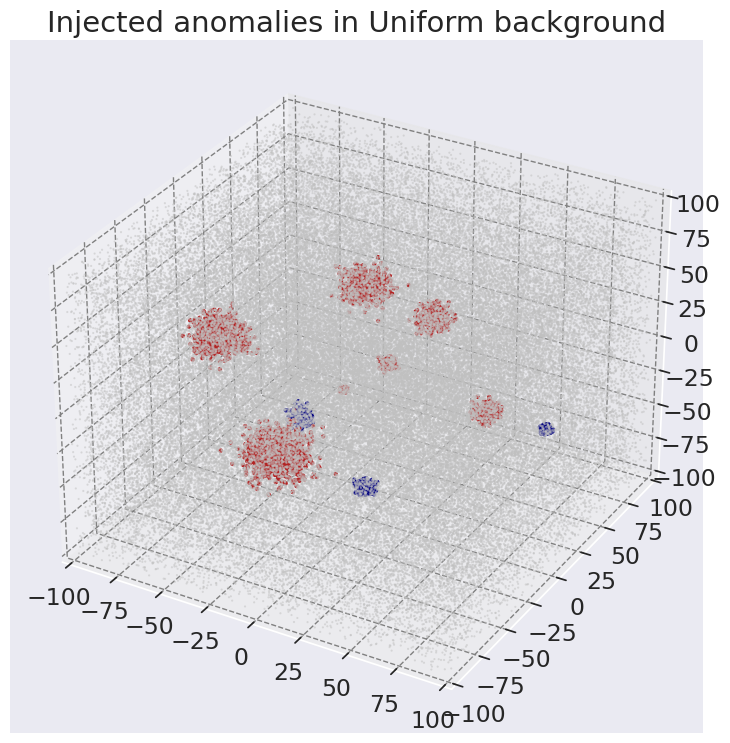

In [5]:
from utils_37 import plot_injected_anomalies_in_uniform_background

# plot of the generated dataset. In silver the background only
# in red the injected overdensities and in blue the injected underdensities
plot_injected_anomalies_in_uniform_background(reference_data, anomaly_sizes_u, test_data, anomaly_sizes_o)

## 2. EagleEye_v7

Reference dataset: $\mathbf{X}$

Test dataset:      $\mathbf{Y}$ 

Define: $\mathbf{U} = \mathbf{X} \cup \mathbf{Y}$

COMPUTE: $\forall i\in U,$  $\Upsilon_i $ whith Inject validation for the data belonging to $\mathbf{X}$ 

Revert the order of Reference and Test to get $\forall j\in U,$  $\Upsilon_{j}(rev) $ whith Inject validation for the data belonging to $\mathbf{Y}$ 

In [ ]:
K_M                   = 1000
CRITICAL_QUANTILES    = [ 1-1E-4, 1-1E-5 ]
VALIDATION            = reference_data.shape[0]


NUM_CORES             = 10

result_dictionary     = EagleEye_v7.Soar(
    reference_data, test_data, result_dict_in = {}, K_M = K_M, critical_quantiles = CRITICAL_QUANTILES,
    num_cores=NUM_CORES, validation=VALIDATION, partition_size=100 )



Eagle...Soar!

                               /T /I
                              / |/ | .-~/
                          T\ Y  I  |/  /  _
         /T               | \I  |  I  Y.-~/
        I l   /I       T\ |  |  l  |  T  /
     T\ |  \ Y l  /T   | \I  l   \ `  l Y
 __  | \l   \l  \I l __l  l   \   `  _. |
 \ ~-l  `\   `\  \  \ ~\  \   `. .-~   |
  \   ~-. "-.  `  \  ^._ ^. "-.  /  \   |
.--~-._  ~-  `  _  ~-_.-"-." ._ /._ ." ./
 &gt;--.  ~-.   ._  ~&gt;-"    "\   7   7   ]
^.___~"--._    ~-{  .-~ .  `\ Y . /    |
 &lt;__ ~"-.  ~       /_/   \   \I  Y   : |
   ^-.__           ~(_/   \   &gt;._:   | l______
       ^--.,___.-~"  /_/   !  `-.~"--l_ /     ~"-.
              (_/ .  ~(   /'     "~"--,Y   -=b-. _)
               (_/ .  \  :           / l      c"~o \
                \ /    `.    .     .^   \_.-~"~--.  )
                 (_/ .   `  /     /       !       )/
                  / / _.   '.   .':      /        '
                  ~(_/ .   /    _  `  .-&lt;_
                    /_/ 

#### Overdensities test_set:
result_dictionary['stats']['Upsilon_i_plus'] : $\Upsilon_i, i\in \mathbf{Y} $ 

#### Underdensities reference_set:
result_dictionary['stats']['Upsilon_i_Val_plus'] : $\Upsilon_i, i\in \mathbf{X} $ (the IV one)

#### Overdensities reference_set:
result_dictionary['stats_reverse']['Upsilon_i_plus'] : $\Upsilon_j(rev), j\in \mathbf{X} $ 

#### Underdensities test_set:
result_dictionary['stats_reverse']['Upsilon_i_Val_plus'] : $\Upsilon_j(rev), j\in \mathbf{Y} $ (the IV one)

### 2.1 Visualize the putative anomalous points

Plot values marked as putative anomalies. 

The overdensities within the test dataset are colored based on their $\Upsilon_i $ with red cmap.

The overdensities within the reference dataset are colored based on their $\Upsilon_i(rev) $ with blue cmap.


In [ ]:
from utils_37 import     plot_data_points_marked_as_putative_anomalies


plot_data_points_marked_as_putative_anomalies(test_data, reference_data, result_dictionary )

## 3 Iterative Equalization

Pipeline for
#### Overdensities test_set:
result_dictionary['stats']['Upsilon_i_plus'] : $\Upsilon_i, i\in \mathbf{Y}$; 

1) While $\exists i \in \mathbf{Y}$ such that $\Upsilon_i \geq \Upsilon_*$;

2) Identify the index $i_{max}$ such that maximize $\Upsilon_{i_{max}} = \max_{i\in \mathbf{Y}}{\Upsilon_i}$;

3) Remove $i_{\text{max}}$ and its nearest neighbours up to the next $\mathbf{X}$ data point from the set $\mathbf{Y}$. Store all removed points in a new set $\mathbf{W_o}$. Update the set $\mathbf{U} = \mathbf{U} \setminus \mathbf{W_o}$;

4)  Recompute $\Upsilon_i, i\in \mathbf{Y}$ for the remaining points in $\mathbf{Y}$ that still exceed $\Upsilon_*$, restricting the nearest-neighbour search to updated $\mathbf{U}$ that do not include points in $\mathbf{W_o}$.

5) Return to point 1)

Pipeline for
#### Overdensities reference_set:
result_dictionary['stats_reverse']['Upsilon_i_plus'] : $\Upsilon_j(rev), j\in \mathbf{X} $ 

1) While $\exists j \in \mathbf{X}$ such that $\Upsilon_j(rev) \geq \Upsilon_*$;

2) Identify the index $j_{max}$ such that maximize $\Upsilon_{j_{max}}(rev) = \max_{j\in \mathbf{X}}{\Upsilon_j}(rev)$;

3) Remove $j_{\text{max}}$ and its nearest neighbours up to the next $\mathbf{Y}$ data point from the set $\mathbf{X}$. Store all removed points in a new set $\mathbf{W_u}$. Update the set $\mathbf{U} = \mathbf{U} \setminus \mathbf{W_u}$; 

4)  Recompute $\Upsilon_j(rev), j\in \mathbf{X}$ for the remaining points in $\mathbf{X}$ that still exceed $\Upsilon_*$, restricting the nearest-neighbour search to updated $\mathbf{U}$ that do not include points in $\mathbf{W_u}$.

5) Return to point 1)




### 3.1 Visualize $\mathbf{W_o}$ and $\mathbf{W_u}$

Plot values marked extracted by iterative equalization. 

The overdensities within the test dataset $\mathbf{W_o}$ are colored in red.

The overdensities within the reference dataset $\mathbf{W_u}$ are colored blue.


In [ ]:
from utils_37 import     plot_points_extracted_by_iterative_equalization
qt = 1 # which of the given quantiles to consider
plot_points_extracted_by_iterative_equalization( test_data, reference_data, result_dictionary, threshold=CRITICAL_QUANTILES[qt] )


## 4 Clustering and aggregating

In order to get statistics from our computaitons let us partition the datapoints such that $\Upsilon_i, i\in \mathbf{Y}$ and $\Upsilon_j(res), j\in \mathbf{X}$ that were inititaly greater then $\Upsilon_*$:

#### Overdensities test_set:
result_dictionary['stats']['Upsilon_i_plus'] : $\Upsilon_i, i\in \mathbf{Y} $ 

#### Overdensities reference_set:
result_dictionary['stats_reverse']['Upsilon_i_plus'] : $\Upsilon_j(rev), j\in \mathbf{X} $ 



### 4.1 Intersect the thus obtained clusters with $\mathbf{W_o}$ and $\mathbf{W_u}$

#### 4.1.1 Overdensities test:

##### 1) Within each overdensity cluster identify the $i_{loc}$ such that $\Upsilon_{i_{loc}} = \min_{i \in \mathbf{W_o}}\Upsilon_{i} $

##### 2) Within each overdensity cluster keep all points such that $\Upsilon_{i} >= \Upsilon_{i_{loc}}, i\in \mathbf{U}$.


##### 3) Get the desired statistics by separatelly considering those comming fom \mathbf{X} (background whithin that cluster) and those comming from \mathbf{Y}.


#### 4.1.2 :Overdensities reference (underdensities):

##### 1) Within each overdensity cluster identify the $j_{loc}$ such that $\Upsilon_{j_{loc}}(rev) = \min_{j \in \mathbf{W_u}}\Upsilon_{j}(rev) $

##### 2) Within each overdensity cluster keep all points such that $\Upsilon_{j}(rev) >= \Upsilon_{j_{loc}}(rev), j\in \mathbf{U}$.


##### 3) Get the desired statistics by separatelly considering those comming fom \mathbf{Y} (test underdensities belonging to that cluster) and those comming from \mathbf{X}.


In [ ]:
#%% # Clustering

clusters = EagleEye_v7.partitian_function(reference_data,test_data,result_dictionary,result_dictionary['Upsilon_star_plus'][qt], result_dictionary['Upsilon_star_minus'][qt],K_M=K_M)

#clusters_plus,clusters_minus = clusters

#%% # Creation of the dictionaries
IV_IE_dict = EagleEye_v7.IV_IE_get_dict(clusters,result_dictionary,[CRITICAL_QUANTILES[qt]],test_data,reference_data)



#### Structure of the dictionary containing the results
    IV_IE_dict = {
    "OVER_clusters": {
        i: {"IE_extra": None, "From_test": None, "From_ref": None}
        for i in range(len(clusters_plus))
    },
    "UNDER_clusters": {
        i: {"IE_extra": None, "From_test": None, "From_ref": None}
        for i in range(len(clusters_minus))
    }
    }

### 4.2 Visualize Clustered Overdensities and Underdensities 

#### 4.2.1 Clustering of points removed by itarative equalization

In [ ]:
from utils_37 import plot_3d_ie_extra

plot_3d_ie_extra(IV_IE_dict, test_data, reference_data)


#### 4.2.2 Clustering of aggregaed Overdensities wrt test data ( shades of reds ) and reference data (shades of blus)

In [ ]:
from utils_37 import plot_3d_second

# Clustering of anomalous points:
plot_3d_second(IV_IE_dict, test_data, reference_data)


#### 4.2.3 Clustering of aggregated Underdensities in the test dataset (red) and refereference dataset (blus)

In [ ]:
from utils_37 import plot_3d_third


# Background from the opposite dataset wrt the clustered anomalies:
plot_3d_third(IV_IE_dict, test_data, reference_data)
